# **Random Forest Regressor**

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer
from scipy.stats import skew, kurtosis
import time

## Importing Data

In [ ]:
df = pd.read_excel('Backhoe_Emission.xlsx').drop(columns='No')
df

,Backhoe,HP(watt),Norm_MAP,RPM,Age,Engine_Tier,TEMP[C],NOx[g/s]
0,1,65621.6,0.000000,833.0,12,2,22.0,0.024090
1,1,65621.6,0.012346,800.0,12,2,22.0,0.030320
2,1,65621.6,0.012346,826.0,12,2,22.0,0.030730
3,1,65621.6,0.012346,831.0,12,2,22.0,0.023693
4,1,65621.6,0.012346,834.0,12,2,22.0,0.026107
...,...,...,...,...,...,...,...,...
37523,8,72332.9,0.975904,1676.0,36,2,41.0,0.058830
37524,8,72332.9,0.975904,1683.0,36,2,42.0,0.059500
37525,8,72332.9,0.975904,1846.0,36,2,42.0,0.059640
37526,8,72332.9,0.987952,1876.0,36,2,42.0,0.056200


## Preprocessing

### Missing Values

In [3]:
df.isna().sum()

Backhoe        0
HP(watt)       0
Norm_MAP       0
RPM            1
Age            0
Engine_Tier    0
TEMP[C]        1
NOx[g/s]       0
dtype: int64

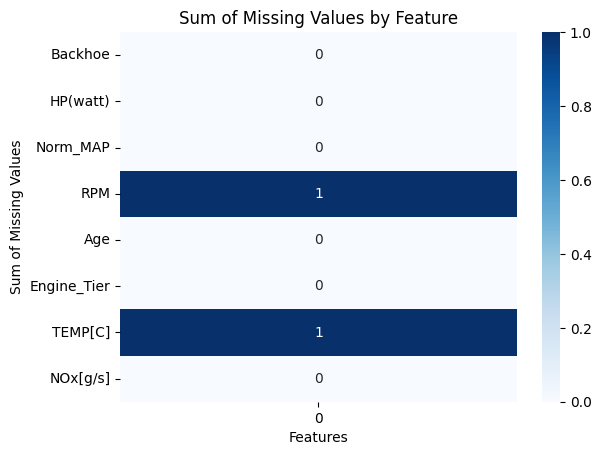

In [4]:
sns.heatmap(df.isnull().sum().to_frame(), annot=True, cmap='Blues')
plt.xlabel('Features')
plt.ylabel('Sum of Missing Values')
plt.title('Sum of Missing Values by Feature')
plt.show()

In [5]:
df.dropna(inplace=True)

In [6]:
df.isna().sum()

Backhoe        0
HP(watt)       0
Norm_MAP       0
RPM            0
Age            0
Engine_Tier    0
TEMP[C]        0
NOx[g/s]       0
dtype: int64

### Duplicates

In [7]:
df.duplicated().sum()

1870

### Desciptive Analysis

In [8]:
df_describe = df.describe().T
df_describe = df_describe.drop(columns=['count', '25%', '50%', '75%'], axis=1)
df_describe['range'] = df_describe['max'] - df_describe['min']
df_describe['variance'] = df_describe['std'] ** 2
def get_mode(x):
    mode_values = x.mode().values
    if len(mode_values) == 1:
        return mode_values[0]
    else:
        return ', '.join(map(str, mode_values))

df_describe['mode'] = df.apply(get_mode)
df_describe

,mean,std,min,max,range,variance,mode
Backhoe,4.097903,2.402267,1.00000,8.00000,7.00000,5.770887e+00,2.00000
HP(watt),69085.239092,3799.646439,65621.60000,73824.30000,8202.70000,1.443731e+07,65621.60000
Norm_MAP,0.205430,0.172965,0.00000,1.01250,1.01250,2.991697e-02,0.04000
RPM,1285.718099,405.758652,92.00000,5000.00000,4908.00000,1.646401e+05,902.00000
Age,73.321608,26.266663,12.00000,96.00000,84.00000,6.899376e+02,84.00000
Engine_Tier,1.257601,0.558013,0.00000,2.00000,2.00000,3.113780e-01,1.00000
TEMP[C],41.096399,15.470683,12.00000,127.00000,115.00000,2.393420e+02,30.00000
NOx[g/s],0.030345,0.019430,0.00123,0.16052,0.15929,3.775173e-04,0.01629


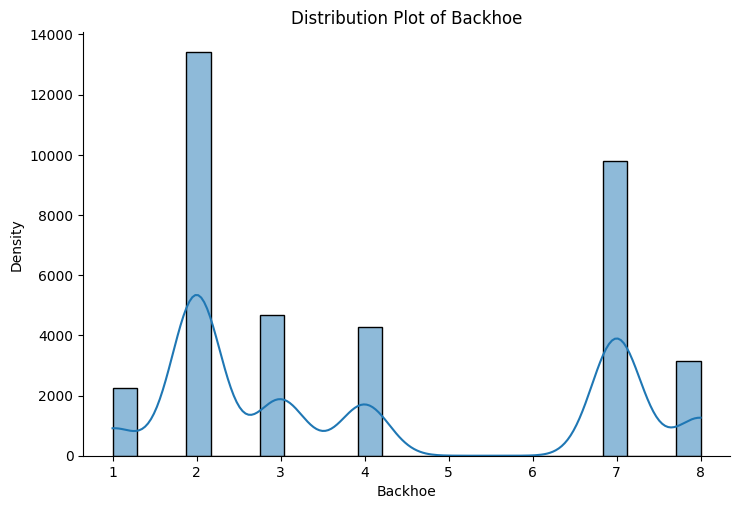

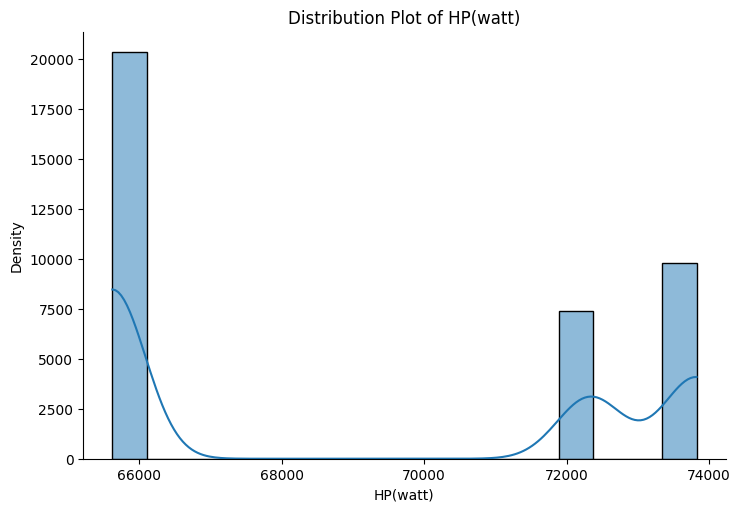

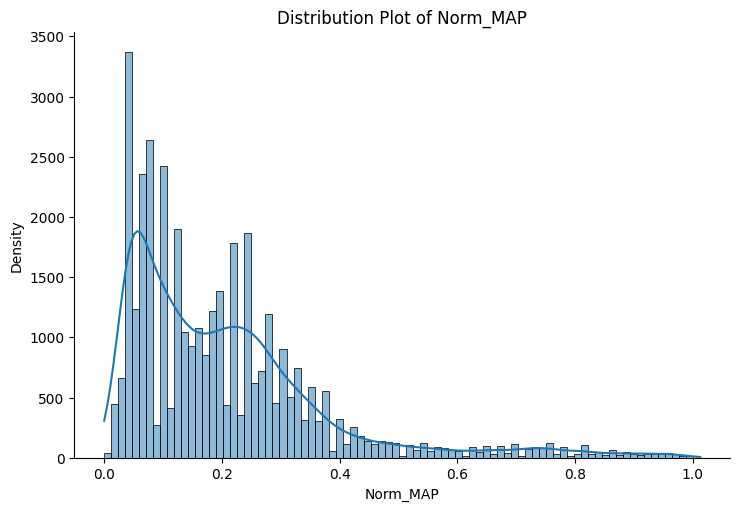

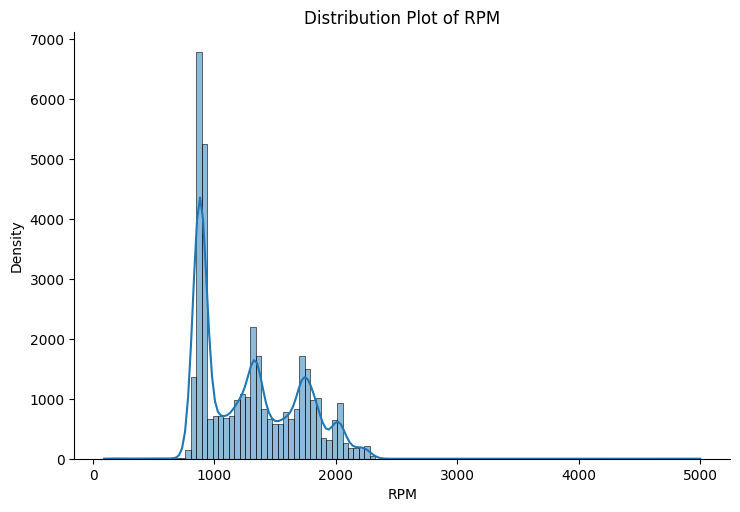

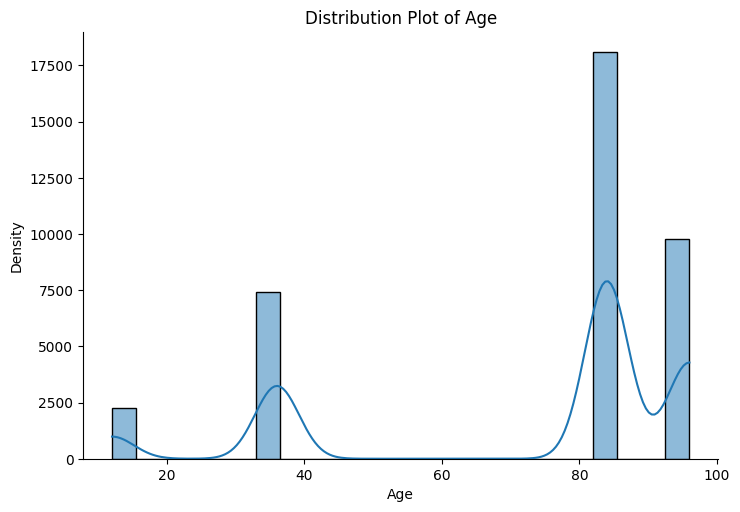

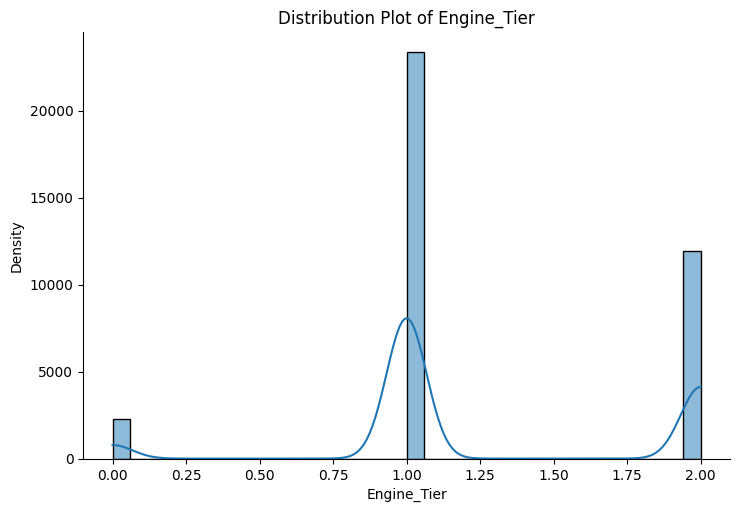

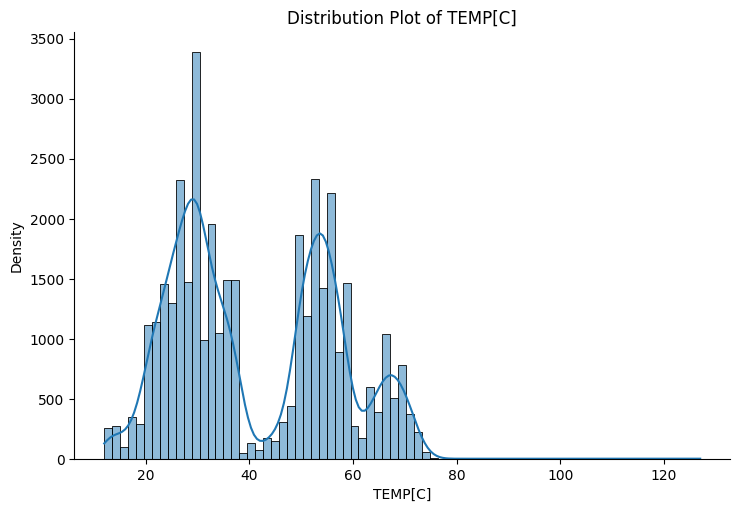

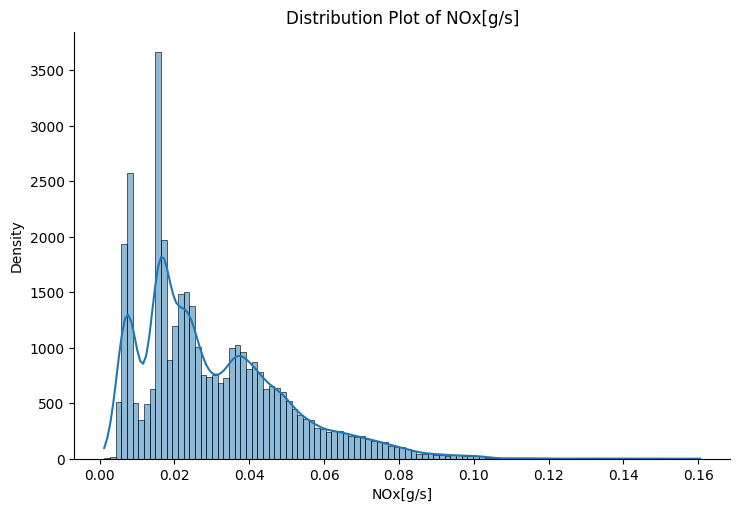

In [9]:
for column in df.columns:
    sns.displot(df[column], kde=True, height=5, aspect=1.5)
    plt.title(f'Distribution Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.show()

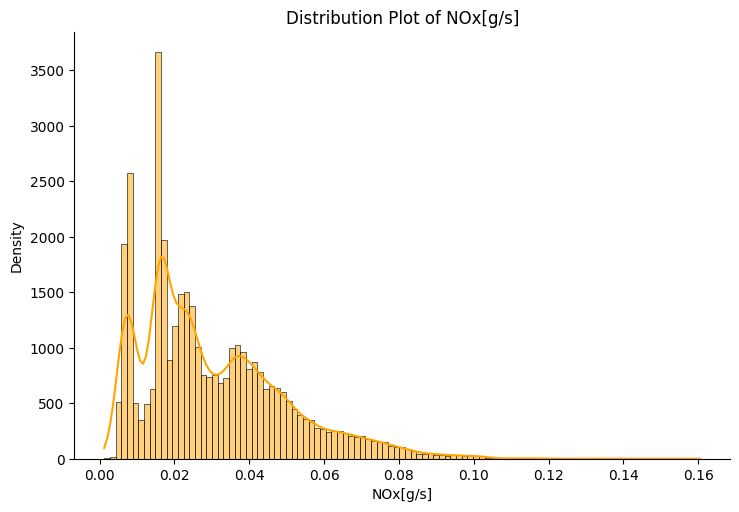

In [10]:
sns.displot(df['NOx[g/s]'], kde=True, height=5, aspect=1.5, color='orange')
plt.title('Distribution Plot of NOx[g/s]')
plt.xlabel('NOx[g/s]')
plt.ylabel('Density')
plt.show()

### Skewness & Kurtosis

In [11]:
skewness_X = df.drop(columns='NOx[g/s]').apply(lambda x: skew(x, bias=True, nan_policy='omit'))
skewness_y = skew(df['NOx[g/s]'], bias=True, nan_policy='omit')
kurtosis_X = df.drop(columns='NOx[g/s]').apply(lambda x: kurtosis(x, nan_policy='omit'))
kurtosis_y = kurtosis(df['NOx[g/s]'], nan_policy='omit')

In [12]:
print("Skewness independent variables:")
print(skewness_X)
print("\nSkewness dependent variable (NOx[g/s]):")
print(skewness_y)

Skewness independent variables:
Backhoe        0.440079
HP(watt)       0.218597
Norm_MAP       1.807995
RPM            0.592456
Age           -1.130582
Engine_Tier   -0.000693
TEMP[C]        0.264903
dtype: float64

Skewness dependent variable (NOx[g/s]):
1.0385038342630495


In [13]:
print("Kurtosis independent variables:")
print(kurtosis_X)
print("\nKurtosis dependent variable (NOx[g/s]):")
print(kurtosis_y)

Kurtosis independent variables:
Backhoe       -1.482144
HP(watt)      -1.889719
Norm_MAP       3.937857
RPM           -0.305166
Age           -0.253212
Engine_Tier   -0.426777
TEMP[C]       -1.176410
dtype: float64

Kurtosis dependent variable (NOx[g/s]):
1.0443586681328556


### Correlation Test

<Axes: >

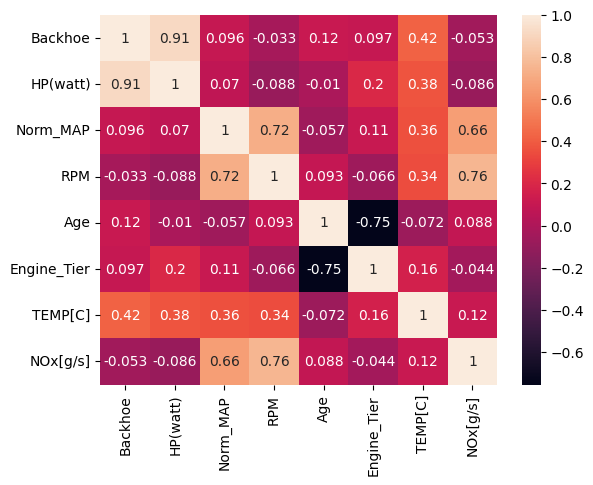

In [14]:
corr_matrix = df.corr(method='pearson')
sns.heatmap(corr_matrix, annot=True)

### Train Test Split

In [15]:
X = df[['HP(watt)', 'Norm_MAP', 'RPM', 'Age', 'Engine_Tier','TEMP[C]']]
y = df['NOx[g/s]']

In [16]:
X.head()

,HP(watt),Norm_MAP,RPM,Age,Engine_Tier,TEMP[C]
0,65621.6,0.000000,833.0,12,2,22.0
1,65621.6,0.012346,800.0,12,2,22.0
2,65621.6,0.012346,826.0,12,2,22.0
3,65621.6,0.012346,831.0,12,2,22.0
4,65621.6,0.012346,834.0,12,2,22.0


In [17]:
y.head()

0    0.024090
1    0.030320
2    0.030730
3    0.023693
4    0.026107
Name: NOx[g/s], dtype: float64

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(26268, 6)
(11259, 6)
(26268,)
(11259,)


### Standaridzation

In [20]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [21]:
X_test_scaled
column_names = X_train.columns

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=column_names)
X_train_scaled_df.head()

,HP(watt),Norm_MAP,RPM,Age,Engine_Tier,TEMP[C]
0,0.856722,0.120079,-0.985892,-1.424270,1.333261,1.022972
1,-0.909959,-0.142326,0.523167,0.405830,1.333261,-0.717838
2,-0.909959,-0.958696,-0.948845,0.405830,-0.456594,-1.169158
3,-0.909959,-1.075321,-0.958724,0.405830,-0.456594,-1.040210
4,1.249318,-1.191945,-1.035288,0.863354,-0.456594,-0.459940


In [22]:
print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)

(26268, 6)
(26268,)
(11259, 6)
(11259,)


## Modelling

In [23]:
rfr =  RandomForestRegressor(random_state=42)

In [24]:
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [25]:
rfr.fit(X_train_scaled,y_train)

RandomForestRegressor(random_state=42)

In [26]:
y_pred = rfr.predict(X_test_scaled)

In [27]:
rfr_table = pd.DataFrame({
    'Predicted NOx (g/s)': y_pred,
    'Actual NOx (g/s)': y_test,
    'Error': np.abs(y_pred - y_test)
})

print(rfr_table)

       Predicted NOx (g/s)  Actual NOx (g/s)     Error
29675             0.031892           0.03617  0.004278
4918              0.068514           0.06710  0.001414
10376             0.026198           0.02744  0.001242
8094              0.044212           0.04414  0.000072
24761             0.012415           0.01547  0.003055
...                    ...               ...       ...
19807             0.023343           0.02237  0.000973
12266             0.007098           0.00798  0.000882
8139              0.035556           0.04986  0.014304
37116             0.025078           0.02438  0.000698
9871              0.024933           0.02859  0.003657

[11259 rows x 3 columns]


In [28]:
# rfr_table.to_excel(r'C:\Users\MSI\Documents\SKRIPSI\Code\HASIL\RFR_Prediction.xlsx', index=False)

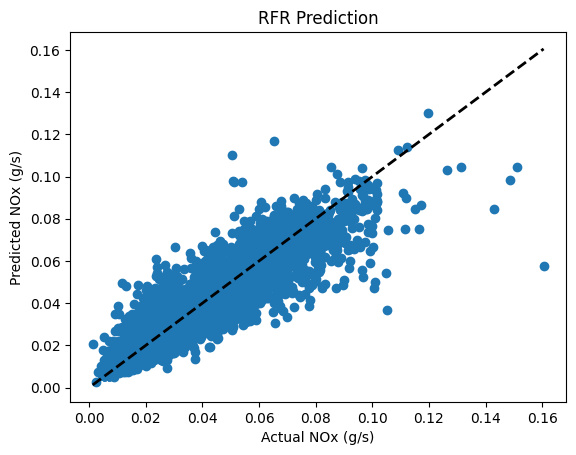

In [29]:
plt.scatter(y_test, y_pred)

# Add a diagonal line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Add labels and title
plt.xlabel('Actual NOx (g/s)')
plt.ylabel('Predicted NOx (g/s)')
plt.title('RFR Prediction')

# Show the plot
plt.show()

In [30]:
print('Training set score: {:.4f}'.format(rfr.score(X_train_scaled, y_train)))

print('Test set score: {:.4f}'.format(rfr.score(X_test_scaled, y_test)))

Training set score: 0.9825
Test set score: 0.8912


### Evaluate

In [56]:
y_train_pred = rfr.predict(X_train_scaled)

In [57]:
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'RMSE: {rmse_train}')

# Calculate MAPE
mape_train= mean_absolute_percentage_error(y_train, y_train_pred)*100
print(f'MAPE: {mape_train}%')

r2_train= r2_score(y_train, y_train_pred)
print(f'R2: {r2_train}')

RMSE: 0.002552647442395214
MAPE: 6.474988088704034%
R2: 0.9825059137864386


In [31]:
# Calculate MSE
dtr_mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {dtr_mse}')

# Calculate MAE
dtr_mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {dtr_mae}')

# Calculate RMSE
dtr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {dtr_rmse}')

# Calculate MAPE
dtr_mape = mean_absolute_percentage_error(y_test,y_pred)*100
print(f'MAPE: {dtr_mape}%')

# Calculate R2
dtr_r2 = r2_score(y_test, y_pred)
print(f'R2: {dtr_r2}')

MSE: 4.23344515996064e-05
MAE: 0.0038786002841199618
RMSE: 0.006506493033855212
MAPE: 14.104165226365833%
R2: 0.8911943927616669


In [32]:
importance = rfr.feature_importances_


column_names = X_train.columns

for i, v in enumerate(importance):
    print(f'Feature {column_names[i]}: {v}')

Feature HP(watt): 0.01670195045653133
Feature Norm_MAP: 0.08483327236308606
Feature RPM: 0.758884830076113
Feature Age: 0.039138280166460516
Feature Engine_Tier: 0.011059532403557008
Feature TEMP[C]: 0.08938213453425205


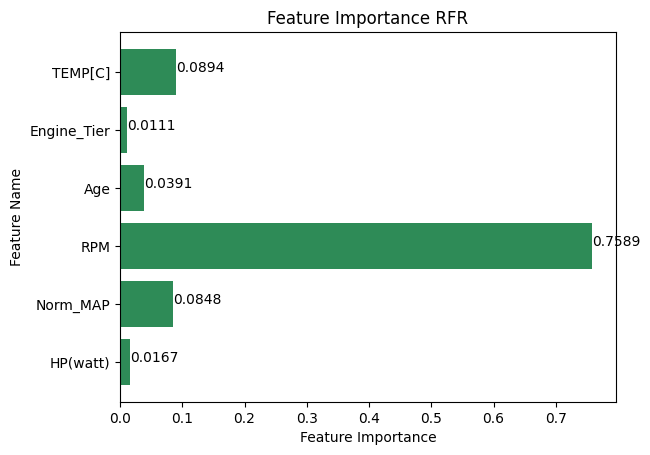

In [33]:
feature_importances = rfr.feature_importances_
feature_names = X_train.columns

# Create the horizontal bar chart
plt.barh(feature_names, feature_importances, color= 'seagreen')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance RFR')

# Annotate each bar with the feature importance value
for index, value in enumerate(feature_importances):
    plt.text(value, index, f'{value:.4f}')  # Format the value to two decimal places

plt.show()

### Cross Val

In [34]:
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))

In [35]:
scores = cross_val_score(rfr, X_train_scaled, y_train, cv=5, scoring=rmse_scorer)
scores

array([0.00622908, 0.0060769 , 0.00630193, 0.00631772, 0.00615397])

In [55]:
print("Mean cross-validation score: {:.7f} ± {:.4f}".format(scores.mean(), scores.std()))

Mean cross-validation score: 0.0062159 ± 0.0001


## Hyperparameter Tuning

In [37]:
param = {
    'n_estimators' : [100, 200, 300],
    'max_depth' : [10, 20, 30],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4]
}

rmse_scorer = make_scorer(mean_squared_error, squared=False)

In [38]:
grid = GridSearchCV(
    rfr,
    param,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring= {'RMSE': rmse_scorer},
    refit='RMSE'
)

start_time = time.time()
grid.fit(X_train_scaled, y_train)

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
print("Best RMSE:", grid.best_score_)
print("Execution time: " + str((time.time() - start_time)) + ' s')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best: 0.006317 using {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best RMSE: 0.006316728158095386
Execution time: 417.43827390670776 s


In [39]:
best_grid = grid.best_estimator_
best_grid

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      random_state=42)

In [40]:
y_pred_grid = best_grid.predict(X_test_scaled)

In [41]:
cv_df = pd.DataFrame(grid.cv_results_)
cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_RMSE,split1_test_RMSE,split2_test_RMSE,split3_test_RMSE,split4_test_RMSE,mean_test_RMSE,std_test_RMSE,rank_test_RMSE
0,4.216020,0.616179,0.092499,0.047760,10,1,2,100,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.006108,0.006137,0.006362,0.006303,0.006335,0.006249,0.000105,24
1,8.596335,0.727808,0.156078,0.022920,10,1,2,200,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.006091,0.006130,0.006354,0.006315,0.006337,0.006245,0.000111,26
2,13.240406,2.123136,0.264857,0.088882,10,1,2,300,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.006090,0.006124,0.006356,0.006313,0.006328,0.006242,0.000112,27
3,4.596496,1.013801,0.075227,0.010029,10,1,5,100,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.006100,0.006155,0.006372,0.006308,0.006341,0.006255,0.000108,20
4,9.079583,1.855728,0.140492,0.018402,10,1,5,200,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.006087,0.006148,0.006364,0.006320,0.006340,0.006251,0.000112,21


In [42]:
cv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean_fit_time            81 non-null     float64
 1   std_fit_time             81 non-null     float64
 2   mean_score_time          81 non-null     float64
 3   std_score_time           81 non-null     float64
 4   param_max_depth          81 non-null     int32  
 5   param_min_samples_leaf   81 non-null     int32  
 6   param_min_samples_split  81 non-null     int32  
 7   param_n_estimators       81 non-null     int32  
 8   params                   81 non-null     object 
 9   split0_test_RMSE         81 non-null     float64
 10  split1_test_RMSE         81 non-null     float64
 11  split2_test_RMSE         81 non-null     float64
 12  split3_test_RMSE         81 non-null     float64
 13  split4_test_RMSE         81 non-null     float64
 14  mean_test_RMSE           81 

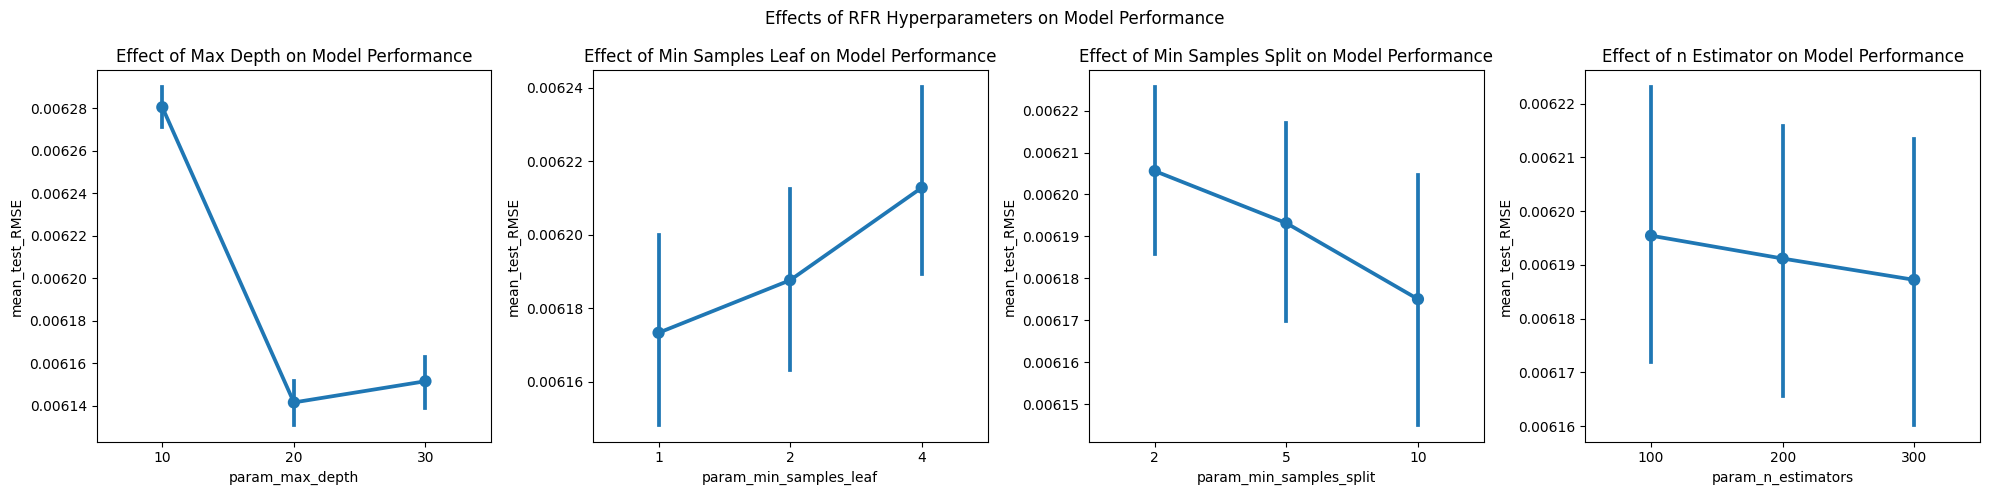

In [43]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Point plot for param_max_depth
sns.pointplot(x='param_max_depth', y='mean_test_RMSE', data=cv_df, ax=axs[0])
axs[0].set(title="Effect of Max Depth on Model Performance")

# Point plot for param_min_samples_leaf
sns.pointplot(x='param_min_samples_leaf', y='mean_test_RMSE', data=cv_df, ax=axs[1])
axs[1].set(title="Effect of Min Samples Leaf on Model Performance")

# Point plot for param_min_samples_split
sns.pointplot(x='param_min_samples_split', y='mean_test_RMSE', data=cv_df, ax=axs[2])
axs[2].set(title="Effect of Min Samples Split on Model Performance")

# Point plot for param_criterion
sns.pointplot(x='param_n_estimators', y='mean_test_RMSE', data=cv_df, ax=axs[3])
axs[3].set(title="Effect of n Estimator on Model Performance")

fig.suptitle("Effects of RFR Hyperparameters on Model Performance")

plt.tight_layout()
plt.show()

In [44]:
# pd.DataFrame(grid.cv_results_).to_excel(r'C:\Users\MSI\Documents\SKRIPSI\Code\TUNING\Grid_RFR_CV.xlsx', index=False)

In [45]:
# Calculate MSE
mse_grid = mean_squared_error(y_test, y_pred_grid)
print(f'MSE: {mse_grid}')

# Calculate MAE
mae_grid = mean_absolute_error(y_test, y_pred_grid)
print(f'MAE: {mae_grid}')

# Calculate RMSE
rmse_grid = np.sqrt(mean_squared_error(y_test, y_pred_grid))
print(f'RMSE: {rmse_grid}')

# Calculate MAPE
mape_grid = mean_absolute_percentage_error(y_test,y_pred_grid)*100
print(f'MAPE: {mape_grid}%')

# Calculate R2
r2_grid = r2_score(y_test, y_pred_grid)
print(f'R2: {r2_grid}')

MSE: 4.3027086518777216e-05
MAE: 0.00386538471608283
RMSE: 0.006559503526851496
MAPE: 14.003433812378606%
R2: 0.8894142217631709


In [46]:
y_train_pred_grid = best_grid.predict(X_train_scaled)

In [47]:
rmse_grid_train = np.sqrt(mean_squared_error(y_train, y_train_pred_grid))
print(f'RMSE: {rmse_grid_train}')

# Calculate MAPE
mape_grid_train= mean_absolute_percentage_error(y_train, y_train_pred_grid)*100
print(f'MAPE: {mape_grid_train}%')

r2_grid_train= r2_score(y_train, y_train_pred_grid)
print(f'R2: {r2_grid_train}')

RMSE: 0.0056811108351240945
MAPE: 12.68398473606788%
R2: 0.9133484942918674


In [48]:
print('Training set score: {:.4f}'.format(best_grid.score(X_train_scaled, y_train)))

print('Test set score: {:.4f}'.format(best_grid.score(X_test_scaled, y_test)))

Training set score: 0.9133
Test set score: 0.8894


In [49]:
grid_table = pd.DataFrame({
    'Predicted NOx (g/s)': y_pred_grid,
    'Actual NOx (g/s)': y_test,
    'Error': np.abs(y_pred_grid - y_test)
})

print(grid_table)

       Predicted NOx (g/s)  Actual NOx (g/s)     Error
29675             0.032942           0.03617  0.003228
4918              0.070271           0.06710  0.003171
10376             0.025801           0.02744  0.001639
8094              0.037155           0.04414  0.006985
24761             0.014274           0.01547  0.001196
...                    ...               ...       ...
19807             0.022814           0.02237  0.000444
12266             0.007151           0.00798  0.000829
8139              0.037727           0.04986  0.012133
37116             0.024367           0.02438  0.000013
9871              0.024608           0.02859  0.003982

[11259 rows x 3 columns]


In [50]:
# grid_table.to_excel(r'C:\Users\MSI\Documents\SKRIPSI\Code\HASIL\RFR_GRID_Prediction.xlsx', index=False)

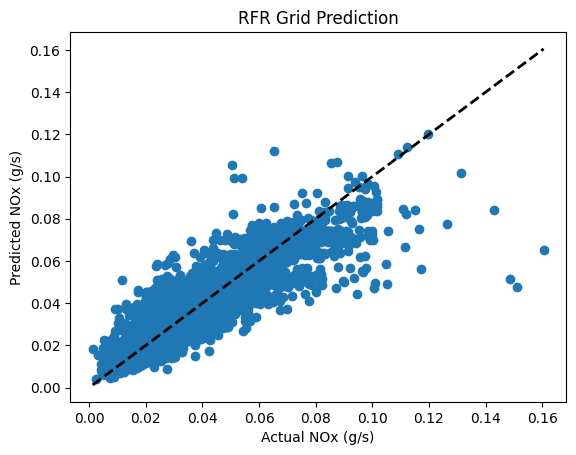

In [51]:
plt.scatter(y_test, y_pred_grid)

# Add a diagonal line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Add labels and title
plt.xlabel('Actual NOx (g/s)')
plt.ylabel('Predicted NOx (g/s)')
plt.title('RFR Grid Prediction')

# Show the plot
plt.show()

In [52]:
print('Training set score: {:.4f}'.format(best_grid.score(X_train_scaled, y_train)))

print('Test set score: {:.4f}'.format(best_grid.score(X_test_scaled, y_test)))

Training set score: 0.9133
Test set score: 0.8894


In [53]:
importance_grid = best_grid.feature_importances_


column_names_grid = X_train.columns

for i, v in enumerate(importance_grid):
    print(f'Feature {column_names_grid[i]}: {v}')

Feature HP(watt): 0.018006793484588824
Feature Norm_MAP: 0.07177120931466734
Feature RPM: 0.7818981700809515
Feature Age: 0.04170345461789344
Feature Engine_Tier: 0.008172453318123931
Feature TEMP[C]: 0.07844791918377483


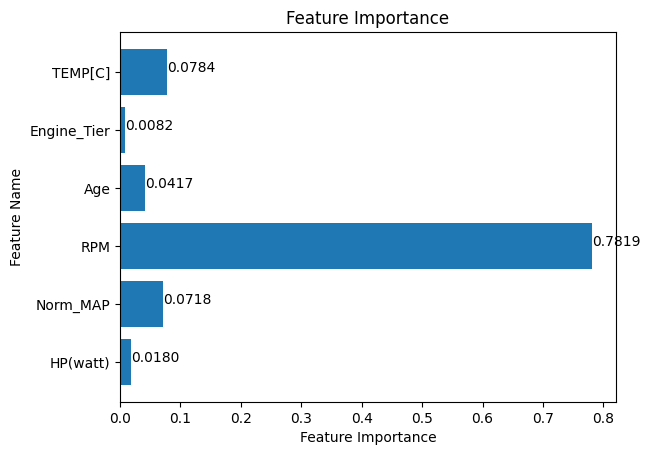

In [54]:
feature_importances_grid = best_grid.feature_importances_
feature_names_grid = X_train.columns

# Create the horizontal bar chart
plt.barh(feature_names_grid, feature_importances_grid)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance')

# Annotate each bar with the feature importance value
for index, value in enumerate(feature_importances_grid):
    plt.text(value, index, f'{value:.4f}')  # Format the value to two decimal places

plt.show()